# Import Librarties

In [ ]:
 import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import string
import time
from gensim.models import KeyedVectors
from tqdm import tqdm_notebook
import os
from os import listdir 
import matplotlib.pyplot as plt 
from torch.optim import Adam
from ast import literal_eval
from datetime import datetime
from sklearn.metrics import confusion_matrix
pd.set_option('max_colwidth',100)
import matplotlib.style
import matplotlib as mpl
mpl.style.use('bmh')

In [ ]:
random.seed(134)
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 50000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Processing

## Build vocab from pretrained word embeddings

In [ ]:
# build vocab from fasttext embeddings 

def build_vocab(word2vec_source, max_vocab_size): 
    """ Takes pretrained word2vec source path, limits to max_vocab_size, and returns:  
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices 
        - word_emb: dictionary representing word embeddings 
    """
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_source, limit=max_vocab_size)
    id2token = word2vec_model.index2word
    token2id = dict(zip(id2token, range(2, 2+len(id2token))))
    id2token = ['<pad>', '<unk>'] + id2token 
    word_emb = {token2id[w]: word2vec_model[w] for w in word2vec_model.vocab}

    return id2token, token2id, word_emb

In [ ]:
id2token, token2id, word_emb = build_vocab('/content/drive/My Drive/Stanford Natural Language Inference/wiki-news-300d-1M.vec', MAX_VOCAB_SIZE)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# convert word_emb from dict to matrix 
pretrained_weights = np.zeros((MAX_VOCAB_SIZE+2, 300))
for idx in word_emb: 
    try: 
        pretrained_weights[idx] = word_emb[idx]
    except KeyError: 
        pretrained_weights[idx] = np.random.normal(size=(300,))
pretrained_weights = torch.from_numpy(pretrained_weights.astype(np.float32)).to(device)

## Load data and convert to indices

In [ ]:
#load data into pandas dataframe 
snli_train = pd.read_table('/content/drive/My Drive/Stanford Natural Language Inference/snli_train.tsv')
snli_val = pd.read_table('/content/drive/My Drive/Stanford Natural Language Inference/snli_val.tsv')
#mnli_train = pd.read_table('hw2_data/mnli_train.tsv')
#mnli_val = pd.read_table('hw2_data/mnli_val.tsv')
print(len(snli_train), len(snli_val)) 
      #len(mnli_train), len(mnli_val))

100000 1000


In [ ]:
snli_train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock viewing a body of water .,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her is focused on a blue object with a pattern on it .,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and tenants,neutral
3,a man in white shorts and a black shirt is paragliding on the ocean,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green grass .,Four dogs are preparing to be launched into space .,contradiction


In [ ]:
# helper methods to convert pandas df to lists of word indices and labels 

label_dict = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

def token_to_index_datum(datum_tokens, token2id): 
    """ Converts a list of tokens and converts it to a list of token indices for one datum """ 
    index_list = [token2id[token] if token in token2id else UNK_IDX for token in datum_tokens]
    return index_list 

def df_to_list(data_df, token2id): 
    """ Takes train/val data as pandas df and returns: 
        - list of lists of word indices representing first sentence 
        - list of lists of word indices representing second sentence 
        - list of ground truth labels indicating entailment/contradiction/neutrality of two sentences 
    """
    sent1 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence1'].tolist()] 
    sent2 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence2'].tolist()] 
    labels = [label_dict[label] for label in data_df['label'].tolist()] 
    return sent1, sent2, labels

In [ ]:
# convert data to indices 
snli_train_sent1, snli_train_sent2, snli_train_labels = df_to_list(snli_train, token2id)
snli_val_sent1, snli_val_sent2, snli_val_labels = df_to_list(snli_val, token2id)
#mnli_train_sent1, mnli_train_sent2, mnli_train_labels = df_to_list(mnli_train, token2id)
#mnli_val_sent1, mnli_val_sent2, mnli_val_labels = df_to_list(mnli_val, token2id)

Text(0, 0.5, 'Label')

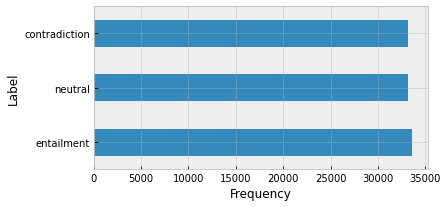

In [ ]:
# check distribution of labels 
plt.figure(figsize=(6, 3))
snli_train['label'].value_counts().plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Label')

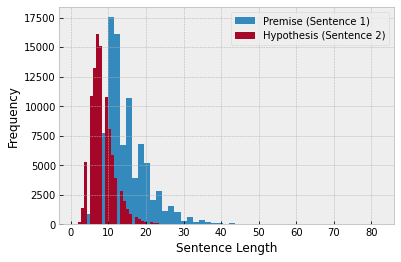

In [ ]:
# check distribution of sentence lengths 
plt.figure(figsize=(6, 4))
snli_train['sentence1'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='Premise (Sentence 1)')
snli_train['sentence2'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='Hypothesis (Sentence 2)')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
# based on results above, we set our max_sentence_length to 40 which covers all of sentence2 and most of sentence1 
MAX_SENTENCE_LENGTH = 40

## Build PyTorch Dataloader

In [ ]:
# helper functions to create dataloader 

class SNLI_Dataset(Dataset): 
    """ 
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset    
    """
    
    def __init__(self, sent1_list, sent2_list, label_list): 
        """ 
        Initialize dataset by passing in the sent and label lists, along with max_sent_length 
        """
        self.sent1_list = sent1_list
        self.sent2_list = sent2_list 
        self.label_list = label_list
        assert (len(self.sent1_list) == len(self.sent2_list) == len(self.label_list))
        
    def __len__(self): 
        return len(self.label_list)
    
    def __getitem__(self, key): 
        """
        Triggered when dataset[i] is called, outputs a list of tokens, lengths of lists, and label of the data point
        """
        sent1_idx = self.sent1_list[key][:MAX_SENTENCE_LENGTH]
        sent2_idx = self.sent2_list[key][:MAX_SENTENCE_LENGTH]    
        sent1_len = len(sent1_idx)
        sent2_len = len(sent2_idx)
        label = self.label_list[key]
        return [sent1_idx, sent2_idx, sent1_len, sent2_len, label]
    
def collate_func(batch): 
    """Customized function for DataLoader that dynamically pads the batch 
       so that all data have the same length""" 
    
    sents1 = [] 
    sents2 = [] 
    sent1_lens = [] 
    sent2_lens = [] 
    labels = [] 

    for datum in batch:
        sent1_lens.append(datum[2])
        sent2_lens.append(datum[3])
        labels.append(datum[4])
        
        # pad data before appending 
        padded_vec1 = np.pad(array=np.array(datum[0]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[2])), 
                             mode = 'constant', constant_values = 0)
        padded_vec2 = np.pad(array=np.array(datum[1]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[3])), 
                             mode = 'constant', constant_values = 0)
        sents1.append(padded_vec1)
        sents2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(sents1)), torch.from_numpy(np.array(sents2)), 
            torch.LongTensor(sent1_lens), torch.LongTensor(sent2_lens), torch.LongTensor(labels)]

def create_data_loader(sent1_list, sent2_list, label_list): 
    """ Takes index lists of sentence1, setence2, and labels for a given dataset and returns a data loader """
    data_set = SNLI_Dataset(sent1_list, sent2_list, label_list)
    data_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=BATCH_SIZE, 
                                              collate_fn=collate_func, shuffle=False)
    return data_loader

In [ ]:
#create data loaders 
snli_train_loader = create_data_loader(snli_train_sent1, snli_train_sent2, snli_train_labels)
snli_val_loader = create_data_loader(snli_val_sent1, snli_val_sent2, snli_val_labels)

In [ ]:
for i, (sent1_idx, sent2_idx, sent1_len, sent2_len, label) in enumerate(snli_train_loader):
    print(i)
    print(sent1_idx)
    print(sent2_idx)
    print(sent1_len)
    print(sent2_len)
    print(label)
    break

0
tensor([[  106,   802,  1830,  ...,     0,     0,     0],
        [  106,   994,    15,  ...,     0,     0,     0],
        [17790,     3,  1938,  ...,     0,     0,     0],
        ...,
        [ 3799,  5700,  5367,  ...,     0,     0,     0],
        [ 2129,    34, 14364,  ...,     0,     0,     0],
        [  106,  5895,   194,  ...,     0,     0,     0]])
tensor([[ 106,  802, 1830,  ...,    0,    0,    0],
        [1442,   67,   34,  ...,    0,    0,    0],
        [  22,  542,  402,  ...,    0,    0,    0],
        ...,
        [  22, 5700,   34,  ...,    0,    0,    0],
        [ 106,  347, 2784,  ...,    0,    0,    0],
        [ 106,  347, 5822,  ...,    0,    0,    0]])
tensor([17, 22, 11, 14, 10, 13, 10,  7, 18, 32, 13, 13, 30, 13, 17, 10, 26, 17,
         8, 13,  8, 13,  8, 25,  9, 15, 12,  7, 21, 10,  9, 10, 10, 10,  9, 24,
        11, 24, 16,  8,  8,  9, 15, 19, 15, 12, 10, 34, 12, 10, 22, 13,  7, 12,
        19, 16, 13,  9, 13, 20, 11, 19, 31, 30])
tensor([10,  8,  9, 1

# Model Architecture

## RNN (Single-Layer GRU)

In [ ]:
# Bi-Directional GRU with dropout 

class rnn_model(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, 
                 pretrained_weights, bidirectional=True, dropout_fc=None):
        super().__init__() 
        self.num_layers, self.hidden_size, self.bidirectional, self.dropout_fc = num_layers, hidden_size, bidirectional, dropout_fc
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(2*2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if self.bidirectional: 
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        else: 
            hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):

        batch_size = x1.size()[0]

        # run sentence 1 
        _, idx_sort1 = torch.sort(x1_lengths, dim=0, descending=True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        x1, x1_lengths = x1.index_select(0, idx_sort1), x1_lengths.index_select(0, idx_sort1)
        embed1 = self.embedding1(x1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths, batch_first=True)
        self.hidden1 = self.init_hidden(batch_size).to(device)      
        rnn1_out, self.hidden1 = self.rnn1(embed1, self.hidden1)
        rnn1_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn1_out, batch_first=True)
        rnn1_out_final = torch.cat([rnn1_out[:, -1, :self.hidden_size], rnn1_out[:, 0, self.hidden_size:]], dim=1) 
        rnn1_out_final = rnn1_out_final.index_select(0, idx_unsort1)
        
        # run sentence 2 
        _, idx_sort2 = torch.sort(x2_lengths, dim=0, descending=True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
        x2, x2_lengths = x2.index_select(0, idx_sort2), x2_lengths.index_select(0, idx_sort2)
        embed2 = self.embedding2(x2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths, batch_first=True)
        self.hidden2 = self.init_hidden(batch_size).to(device)
        rnn2_out, self.hidden2 = self.rnn2(embed2, self.hidden2)
        rnn2_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn2_out, batch_first=True)
        rnn2_out_final = torch.cat([rnn2_out[:, -1, :self.hidden_size], rnn2_out[:, 0, self.hidden_size:]], dim=1) 
        rnn2_out_final = rnn2_out_final.index_select(0, idx_unsort2)

        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([rnn1_out_final, rnn2_out_final], dim=1)
        if self.dropout_fc is not None: 
            combined = nn.Dropout(p=self.dropout_fc)(combined)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 

        return logits

## CNN

In [ ]:
# 2-layer 1D CNN with ReLU activations 

class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, pretrained_weights, 
                 kernel_size, dropout_fc=None):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size, self.dropout_fc = num_layers, hidden_size, dropout_fc
        
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv11 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size-1)/2)) #, padding=1)
        self.conv12 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size-1)/2)) #, padding=1)
        
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv21 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size-1)/2)) #, padding=1)
        self.conv22 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size-1)/2)) #, padding=1)    
        
        self.fc1 = nn.Linear(2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        embed1 = self.embedding1(x1)
        hidden1 = self.conv11(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = self.conv12(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.leaky_relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = torch.max(hidden1, dim=1)[0]

        embed2 = self.embedding2(x2)
        hidden2 = self.conv21(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv22(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.leaky_relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = torch.max(hidden2, dim=1)[0]
        
        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([hidden1, hidden2], dim=1)
        if self.dropout_fc is not None: 
            combined = nn.Dropout(p=self.dropout_fc)(combined)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 
        
        return logits

# Model Training

In [ ]:
# helper functions to train and test model - save model if best  

def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    all_predictions = [] 
    all_labels = [] 
    
    for sent1s, sent2s, sent1_lens, sent2_lens, labels in loader: 
        sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
        outputs = F.softmax(model(sent1s, sent2s, sent1_lens, sent2_lens), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += labels.size(0)
        correct += predictions.eq(labels.view_as(predictions)).sum().item()
        all_predictions += list(predictions.flatten()) 
        all_labels += list(labels.flatten())
        
    return (100 * correct / total), all_predictions, all_labels 


def train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, print_intermediate=True, 
                   save_checkpoint=False, model_name='default'):  
    """
    Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
    Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
    """
    # train and validate 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    results = []
    for epoch in range(num_epochs):
        for i, (sent1s, sent2s, sent1_lens, sent2_lens, labels) in enumerate(train_loader):
            model.to(device)
            model.train()
            optimizer.zero_grad()
            sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
            outputs = model(sent1s, sent2s, sent1_lens, sent2_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + i / len(train_loader)
                result['train_acc'], _, _ = test_model(train_loader, model)
                result['val_acc'], _, _ = test_model(val_loader, model)       
                results.append(result)

                if save_checkpoint: 
                    if result['val_acc'] == pd.DataFrame.from_dict(results)['val_acc'].max(): 
                        checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
                        torch.save(model.state_dict(), checkpoint_fp)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
                        result['epoch'], result['train_acc'], result['val_acc']))
    return results

In [ ]:
# helper functions to save results to and load results from a pkl logfile 

RESULTS_LOG = 'experiment_results/experiment_results_log_v4_gcp.pkl'

def append_to_log(hyperparams, results, runtime, experiment_name, filename=RESULTS_LOG): 
    """ Appends results and details of a single experiment to a log file """
    
    # create directory if doesn't already exist 
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
        
    # store experiment details in a dictionary 
    new_result = {'experiment_name': experiment_name, 'hyperparams': hyperparams, 'results': results, 
                  'runtime': runtime, 'dt_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    
    # if log already exists, append to log 
    try: 
        results_log = pkl.load(open(filename, "rb"))
        results_log.append(new_result)

    # if log doesn't exists, initialize first result as the log 
    except (OSError, IOError) as e:
        results_log = [new_result]
    
    # save to pickle 
    pkl.dump(results_log, open(filename, "wb"))

In [ ]:
def load_experiment_log(experiment_name=None, filename=RESULTS_LOG): 
    """ Loads experiment log, with option to filter for a specific experiment_name """
    
    results_log = pkl.load(open(filename, "rb"))
    
    if experiment_name is not None: 
        results_log = [r for r in results_log if r['experiment_name'] == experiment_name]
        
    return results_log

In [ ]:
# with dropout 

def run_experiment(train_loader, val_loader, model_type, hidden_size, fc_out_size, 
                   learning_rate, num_epochs, dropout_fc=None, experiment_name='Not_Specified', kernel_size=None, 
                   save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True):  
    
    """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
        Note that the function takes as input tokenized data rather than raw data since there's significant 
        lag time in generating tokens.  
    """
    
    start_time = time.time() 
    
    # instantiate model and optimizer 
    if model_type == 'rnn': 
        model = rnn_model(emb_size=300, hidden_size=hidden_size, num_layers=1, fc_out_size=fc_out_size, 
                          num_classes=3, pretrained_weights=pretrained_weights, dropout_fc=dropout_fc)
    elif model_type == 'cnn': 
        model = CNN(emb_size=300, hidden_size=hidden_size, num_layers=2, fc_out_size=fc_out_size, 
                    num_classes=3, pretrained_weights=pretrained_weights, dropout_fc=dropout_fc, 
                    kernel_size=kernel_size)
    else: 
        raise ValueError("Invalid model_type. Must be either 'cnn' or 'rnn'")
        
    # train and evaluate 
    results = train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, 
                             print_intermediate=print_intermediate, save_checkpoint=save_checkpoint, 
                             model_name=experiment_name)
    
    # store, print, and save results 
    runtime = time.time() - start_time 
    hyperparams = {'model_type': model_type, 'hidden_size': hidden_size, 'fc_out_size': fc_out_size, 
                   'kernel_size': kernel_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 
                   'dropout_fc': dropout_fc}
    if save_to_log: 
        append_to_log(hyperparams, results, runtime, experiment_name)
    if print_summary: 
        print("Experiment completed in {} seconds with {}% validation accuracy.".format(
            int(runtime), pd.DataFrame.from_dict(results)['val_acc'].max()))
        
    return results, hyperparams, runtime, model, train_loader, val_loader

In [ ]:
# helper methods to summarize, evaluate, and plot results 

def summarize_results(results_log): 
    """ Summarizes results_log (list) into a dataframe, splitting hyperparameters string into columns, and reducing 
        the val_acc dict into the best validation accuracy obtained amongst all the epochs logged """
    results_df = pd.DataFrame.from_dict(results_log)
    results_df = pd.concat([results_df, results_df['hyperparams'].apply(pd.Series)], axis=1)
    results_df['val_acc'] = results_df['results'].apply(lambda d: pd.DataFrame.from_dict(d)['val_acc'].max())
    return results_df.sort_values(by='val_acc', ascending=False) 

def plot_multiple_learning_curves(results_df, plot_variable, figsize=(8, 5), legend_loc='best'):
    """ Plots learning curves of MULTIPLE experiments, includes only validation accuracy """
    plt.figure(figsize=figsize)
    for index, row in results_df.iterrows():
        val_acc_hist = pd.DataFrame.from_dict(row['results']).set_index('epoch')['val_acc'] 
        plt.plot(val_acc_hist, label="{} ({}%)".format(row[plot_variable], val_acc_hist.max()))
    plt.legend(title=plot_variable, loc=legend_loc)    
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')

def plot_single_learning_curve(results, figsize=(8, 5)): 
    """ Plots learning curve of a SINGLE experiment, includes both train and validation accuracy """
    results_df = pd.DataFrame.from_dict(results)
    results_df = results_df.set_index('epoch')
    results_df.plot(figsize=figsize)
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')

In [ ]:
# helper function to count parameters 
def count_parameters(model): 
    all_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return all_params, trainable_params

## Train RNN

### Tune hidden_size and fc_out_size together

In [ ]:
# test various combos of hidden size and fc out size 

hidden_sizes = [10, 25, 50, 100, 200]
fc_out_sizes = [100, 200, 300, 500, 750]

for hidden_size in hidden_sizes: 
    for fc_out_size in fc_out_sizes: 
        print ("Training with hidden_size = {} and fc_out_size = {} ...".format(hidden_size, fc_out_size))
    
        # train and evaluate
        results, hyperparams, runtime, _, _, _ = run_experiment(
            train_loader=snli_train_loader, val_loader=snli_val_loader,
            model_type='rnn', hidden_size=hidden_size, fc_out_size=fc_out_size, kernel_size=None, 
            learning_rate=0.001, num_epochs=1, experiment_name='RNN_hidden_fc_out_10epoch', 
            save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with hidden_size = 10 and fc_out_size = 100 ...
Epoch: 0.00, Train Accuracy: 34.13%, Validation Accuracy: 34.40%
Epoch: 0.06, Train Accuracy: 39.00%, Validation Accuracy: 38.10%
Epoch: 0.13, Train Accuracy: 41.66%, Validation Accuracy: 40.70%
Epoch: 0.19, Train Accuracy: 45.15%, Validation Accuracy: 44.40%
Epoch: 0.26, Train Accuracy: 46.74%, Validation Accuracy: 47.30%
Epoch: 0.32, Train Accuracy: 48.91%, Validation Accuracy: 49.00%
Epoch: 0.38, Train Accuracy: 50.53%, Validation Accuracy: 51.20%
Epoch: 0.45, Train Accuracy: 52.78%, Validation Accuracy: 53.80%
Epoch: 0.51, Train Accuracy: 53.97%, Validation Accuracy: 55.30%
Epoch: 0.58, Train Accuracy: 54.24%, Validation Accuracy: 54.70%
Epoch: 0.64, Train Accuracy: 55.38%, Validation Accuracy: 56.90%
Epoch: 0.70, Train Accuracy: 55.08%, Validation Accuracy: 54.80%
Epoch: 0.77, Train Accuracy: 56.54%, Validation Accuracy: 56.40%
Epoch: 0.83, Train Accuracy: 56.79%, Validation Accuracy: 57.50%
Epoch: 0.90, Train Accuracy: 57.0

In [ ]:
# all results 
rnn_hidden_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='RNN_hidden_fc_out_10epoch', filename=RESULTS_LOG))
rnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc']].sort_values(['hidden_size', 'fc_out_size'])

,hidden_size,fc_out_size,num_epochs,runtime,val_acc
3,10,100,1,523.645293,57.5
0,10,100,1,513.975745,57.0
1,10,200,1,515.702374,58.0
4,10,200,1,526.594406,57.8
5,10,300,1,531.161425,57.9
2,10,300,1,521.776049,56.4
6,10,500,1,532.111753,57.5
7,10,750,1,535.781438,57.4
8,25,100,1,685.656217,58.9
9,25,200,1,684.917544,58.6


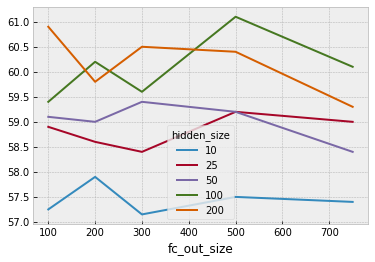

In [ ]:
# plot summary results 
pd.pivot_table(rnn_hidden_fc_out_size_exps, values='val_acc', index='fc_out_size', columns='hidden_size').plot()

In [ ]:
# best RNN model 
rnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc']].sort_values(
    ['val_acc'], ascending=False).head(1)

,hidden_size,fc_out_size,num_epochs,runtime,val_acc
21,100,500,1,1532.782107,61.1


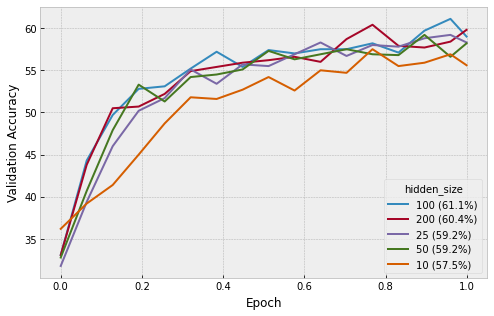

In [ ]:
# ablation with hidden size (set fc_out_size = 500)
rnn_hidden_size_ablation = rnn_hidden_fc_out_size_exps[rnn_hidden_fc_out_size_exps['fc_out_size'] == 500]
plot_multiple_learning_curves(rnn_hidden_size_ablation, 'hidden_size', legend_loc='lower right')

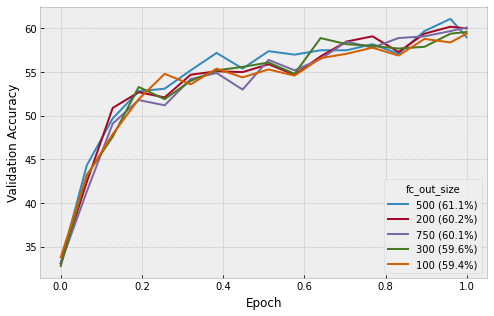

In [ ]:
# ablation with fc_out_size (set hidden_size = 100)
rnn_fc_out_size_ablation = rnn_hidden_fc_out_size_exps[rnn_hidden_fc_out_size_exps['hidden_size'] == 100]
plot_multiple_learning_curves(rnn_fc_out_size_ablation, 'fc_out_size', legend_loc='lower right')

### Test Dropout

In [ ]:
dropout_fcs = [0.5]

for dropout_fc in dropout_fcs: 
    print ("Training with dropout_fc = {} ...".format(dropout_fc))

    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='rnn', hidden_size=100, fc_out_size=500, dropout_fc=dropout_fc, kernel_size=None, 
        learning_rate=0.001, num_epochs=10, experiment_name='RNN_dropout_fc_10epoch', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with dropout_fc = 0.5 ...
Epoch: 0.00, Train Accuracy: 33.48%, Validation Accuracy: 33.80%
Epoch: 0.06, Train Accuracy: 43.21%, Validation Accuracy: 40.40%
Epoch: 0.13, Train Accuracy: 47.20%, Validation Accuracy: 47.10%
Epoch: 0.19, Train Accuracy: 51.85%, Validation Accuracy: 51.40%
Epoch: 0.26, Train Accuracy: 52.92%, Validation Accuracy: 52.80%
Epoch: 0.32, Train Accuracy: 54.20%, Validation Accuracy: 52.70%
Epoch: 0.38, Train Accuracy: 54.56%, Validation Accuracy: 52.70%
Epoch: 0.45, Train Accuracy: 55.48%, Validation Accuracy: 53.60%
Epoch: 0.51, Train Accuracy: 55.31%, Validation Accuracy: 53.70%
Epoch: 0.58, Train Accuracy: 56.36%, Validation Accuracy: 55.10%
Epoch: 0.64, Train Accuracy: 57.03%, Validation Accuracy: 56.90%
Epoch: 0.70, Train Accuracy: 57.61%, Validation Accuracy: 55.40%
Epoch: 0.77, Train Accuracy: 58.10%, Validation Accuracy: 56.00%
Epoch: 0.83, Train Accuracy: 58.23%, Validation Accuracy: 56.30%
Epoch: 0.90, Train Accuracy: 58.58%, Validation Accurac

In [ ]:
# get best without dropout 
optimal = rnn_fc_out_size_ablation[rnn_fc_out_size_ablation['fc_out_size'] == 500].copy()
optimal['dropout_fc'] = 'None'
# concat with dropout 
rnn_dropout_exps = summarize_results(load_experiment_log(experiment_name='RNN_dropout_fc_10epoch_v2', filename=RESULTS_LOG))
rnn_dropout_exps.dropna(subset=['dropout_fc'], inplace=True) 
rnn_dropout_exps = pd.concat([rnn_dropout_exps, optimal], sort=True)  
rnn_dropout_exps = rnn_dropout_exps.sort_values(by='val_acc', ascending=False)
rnn_dropout_exps[['dropout_fc', 'num_epochs', 'runtime', 'val_acc']]

In [ ]:
plot_multiple_learning_curves(rnn_dropout_exps, 'dropout_fc', legend_loc='lower right')


### Retrain and Save Best RNN Model


In [ ]:
# summarize best hyperparameters 
BEST_RNN_MODEL_NAME = 'RNN_100hidden_500fc_10epoch_001lr_v3' #'RNN_100hidden_500fc_10epoch_001lr_v3'
BEST_RNN_HIDDEN_SIZE = 100
BEST_RNN_FC_OUT_SIZE = 500

In [ ]:
# retrain and save final model 
results, hyperparams, runtime, _, _, _ = run_experiment(
    train_loader=snli_train_loader, val_loader=snli_val_loader,
    model_type='rnn', hidden_size=BEST_RNN_HIDDEN_SIZE, fc_out_size=BEST_RNN_FC_OUT_SIZE, kernel_size=None, 
    learning_rate=0.001, num_epochs=10, experiment_name=BEST_RNN_MODEL_NAME, 
    save_to_log=True, save_checkpoint=True, print_summary=True, print_intermediate=True)

In [ ]:
# plot training and test loss for best model 
best_rnn_results = load_experiment_log(experiment_name=BEST_RNN_MODEL_NAME, filename=RESULTS_LOG)[0]['results']
plot_single_learning_curve(best_rnn_results)

## Tune CNN

### Tune Kernel Size

In [ ]:
kernel_sizes = [3, 5, 7]

for kernel_size in kernel_sizes: 
    print ("Training with kernel_size = {} ...".format(kernel_size))
    
    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='cnn', hidden_size=50, fc_out_size=500, kernel_size=kernel_size, 
        learning_rate=0.001, num_epochs=10, experiment_name='CNN_kernel_size_10epoch_v2', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

In [ ]:
# retrieve kernel_size = 3 result from another experiment
kernel_size_3 = summarize_results(load_experiment_log(experiment_name='CNN_hidden_fc_out_size_10epoch', filename=RESULTS_LOG))
kernel_size_3 = kernel_size_3[(kernel_size_3['hidden_size'] == 50) & (best['fc_out_size'] == 500)]
kernel_size_3['kernel_size'] = 3 # note this was previously misrecorded as 4 thus overwriting it 

# combine with other experiments 
kernel_sizes_exps = summarize_results(load_experiment_log(experiment_name='CNN_kernel_size_10epoch_v3', filename=RESULTS_LOG))
kernel_sizes_exps = pd.concat([kernel_sizes_exps, kernel_size_3], sort=False)
kernel_sizes_exps.sort_values(by='val_acc', ascending=False, inplace=True)
kernel_sizes_exps[['kernel_size', 'num_epochs', 'runtime', 'val_acc']]

In [ ]:
# ablation with kernel_size 
plot_multiple_learning_curves(kernel_sizes_exps, 'kernel_size', legend_loc='lower right')

### Tune hidden_size and fc_out_size together

In [ ]:
BEST_KERNEL_SIZE = 3
hidden_sizes = [25, 50, 100, 200]
fc_out_sizes = [100, 200, 300, 500, 750]

for hidden_size in hidden_sizes: 
    for fc_out_size in fc_out_sizes: 
        print ("Training with hidden_size = {} and fc_out_size = {} ...".format(hidden_size, fc_out_size))

        # train and evaluate
        results, hyperparams, runtime, _, _, _ = run_experiment(
            train_loader=snli_train_loader, val_loader=snli_val_loader,
            model_type='cnn', hidden_size=hidden_size, fc_out_size=fc_out_size, kernel_size=BEST_KERNEL_SIZE, 
            learning_rate=0.001, num_epochs=10, experiment_name='CNN_hidden_fc_out_size_10epoch', 
            save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

In [ ]:
cnn_hidden_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='CNN_hidden_fc_out_size_10epoch', filename=RESULTS_LOG))
cnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc', 'learning_rate']].sort_values(['hidden_size', 'fc_out_size'])

In [ ]:
# plot summary results 
pd.pivot_table(cnn_hidden_fc_out_size_exps, values='val_acc', index='fc_out_size', columns='hidden_size').plot();

In [ ]:
# best CNN model 
cnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'kernel_size','num_epochs', 'runtime', 'val_acc']].sort_values(
    ['val_acc'], ascending=False).head(1)

In [ ]:
# ablation with hidden size (set fc_out_size = 500)
cnn_hidden_size_ablation = cnn_hidden_fc_out_size_exps[cnn_hidden_fc_out_size_exps['fc_out_size'] == 500]
plot_multiple_learning_curves(cnn_hidden_size_ablation, 'hidden_size', legend_loc='lower right')

In [ ]:
# ablation with fc_out_size 
cnn_hidden_size_ablation = cnn_hidden_fc_out_size_exps[cnn_hidden_fc_out_size_exps['hidden_size'] == 50]
plot_multiple_learning_curves(cnn_hidden_size_ablation, 'fc_out_size', legend_loc='lower right')

### Test Dropout

In [ ]:
dropout_fcs = [0.5]

for dropout_fc in dropout_fcs: 
    print ("Training with dropout_fc = {} ...".format(dropout_fc))

    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='cnn', hidden_size=50, fc_out_size=500, dropout_fc=dropout_fc, kernel_size=4, 
        learning_rate=0.001, num_epochs=10, experiment_name='CNN_dropout_fc_10epoch', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

In [ ]:
# get best without dropout 
cnn_optimal = cnn_hidden_size_ablation[cnn_hidden_size_ablation['fc_out_size'] == 500].copy()
cnn_optimal['dropout_fc'] = 'None'
# concat with dropout 
cnn_dropout_exps = summarize_results(load_experiment_log(experiment_name='CNN_dropout_fc_10epoch', filename=RESULTS_LOG))
cnn_dropout_exps.dropna(subset=['dropout_fc'], inplace=True) 
cnn_dropout_exps = pd.concat([cnn_dropout_exps, cnn_optimal], sort=True)  
cnn_dropout_exps = cnn_dropout_exps.sort_values(by='val_acc', ascending=False)
cnn_dropout_exps[['dropout_fc', 'num_epochs', 'runtime', 'val_acc']]

In [ ]:
# ablation with kernel_size (with hidden_size=100, fc_out_size=500)
plot_multiple_learning_curves(cnn_dropout_exps, 'dropout_fc', legend_loc='lower right')

### Retrain and Save Best CNN Model


In [ ]:
# summarize best hyperparameters 
BEST_CNN_MODEL_NAME = 'CNN_50hidden_500fc_10epoch_001lr_v2' 
BEST_CNN_KERNEL_SIZE = 3 
BEST_CNN_HIDDEN_SIZE = 50
BEST_CNN_FC_OUT_SIZE = 500
BEST_CNN_DROPOUT_FC = None

In [ ]:
# retrain and save final model 
results, hyperparams, runtime, _, _, _ = run_experiment(
    train_loader=snli_train_loader, val_loader=snli_val_loader,
    model_type='cnn', hidden_size=BEST_CNN_HIDDEN_SIZE, fc_out_size=BEST_CNN_FC_OUT_SIZE, kernel_size=BEST_CNN_KERNEL_SIZE, 
    learning_rate=0.001, num_epochs=10, experiment_name=BEST_CNN_MODEL_NAME, dropout_fc = None, 
    save_to_log=True, save_checkpoint=True, print_summary=True, print_intermediate=True)

In [ ]:
# plot training and test loss for best model 
best_cnn_results = load_experiment_log(experiment_name=BEST_CNN_MODEL_NAME, filename=RESULTS_LOG)[0]['results']
plot_single_learning_curve(best_cnn_results)

# Model Evaluation


## Reload Best Models


In [ ]:
# reload best RNN 
best_rnn_model_snli = rnn_model(emb_size=300, num_layers=1, num_classes=3, pretrained_weights=pretrained_weights,
                                hidden_size=BEST_RNN_HIDDEN_SIZE, fc_out_size=BEST_RNN_FC_OUT_SIZE)
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_RNN_MODEL_NAME), map_location=device)
best_rnn_model_snli.load_state_dict(checkpoint)

In [ ]:
print("The best RNN model has {} parameters, of which {} are trainable.".format(
    count_parameters(best_rnn_model_snli)[0], count_parameters(best_rnn_model_snli)[1]))

In [ ]:
# reload best cnn 
best_cnn_model_snli = CNN(emb_size=300, num_layers=1, num_classes=3, pretrained_weights=pretrained_weights,
                          hidden_size=BEST_CNN_HIDDEN_SIZE, fc_out_size=BEST_CNN_FC_OUT_SIZE, 
                          kernel_size=BEST_CNN_KERNEL_SIZE)
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_CNN_MODEL_NAME), map_location=device)
best_cnn_model_snli.load_state_dict(checkpoint)

In [ ]:
print("The best CNN model has {} parameters, of which {} are trainable.".format(
    count_parameters(best_cnn_model_snli)[0], count_parameters(best_cnn_model_snli)[1]))

## Evaluate Examples from SNLI Validation Set (predict with best rnn model)

In [ ]:
# retest on SNLI validation set 
val_accuracy, val_predictions, val_labels = test_model(snli_val_loader, best_rnn_model_snli)

In [ ]:
# zip val data, labels, and predictions 
val_combined = pd.DataFrame({
    'premise': snli_val['sentence1'], 'hypothesis': snli_val['sentence2'], 
    'label': [t.item() for t in val_labels], 'prediction': [t.item() for t in val_predictions]})
val_combined.head(10)
val_combined['correct'] = np.where(val_combined['label'] == val_combined['prediction'], 1, 0)
label_dict_reverse = dict((v,k) for k,v in label_dict.items())
val_combined['label'] = val_combined['label'].map(label_dict_reverse)
val_combined['prediction'] = val_combined['prediction'].map(label_dict_reverse)

In [ ]:
# select 3 correct examples, one of each label 
pd.set_option('display.max_colwidth', 500)
correct_entailment = val_combined[(val_combined['correct'] == 1) & (val_combined['label'] == 'entailment')].sample(1)
correct_contradiction = val_combined[(val_combined['correct'] == 1) & (val_combined['label'] == 'contradiction')].sample(1)
correct_neutral = val_combined[(val_combined['correct'] == 1) & (val_combined['label'] == 'neutral')].sample(1)
correct_examples = pd.concat([correct_entailment, correct_contradiction, correct_neutral])
correct_examples

In [ ]:
# select 3 incorrect examples, one of each label 
incorrect_entailment = val_combined[(val_combined['correct'] == 0) & (val_combined['label'] == 'entailment')].sample(1)
incorrect_contradiction = val_combined[(val_combined['correct'] == 0) & (val_combined['label'] == 'contradiction')].sample(1)
incorrect_neutral = val_combined[(val_combined['correct'] == 0) & (val_combined['label'] == 'neutral')].sample(1)
incorrect_examples = pd.concat([incorrect_entailment, incorrect_contradiction, incorrect_neutral])
incorrect_examples

## Evaluate on Unseen MNLI Validation Set


In [ ]:
mnli_genres = mnli_train['genre'].unique()
mnli_train['genre'].value_counts()

In [ ]:
mnli_train.head()


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True)
mnli_train['genre'].value_counts().plot(kind='barh', ax=axes[0], title='MultiNLI Train Samples')
mnli_val['genre'].value_counts().plot(kind='barh', ax=axes[1], title='MultiNLI Val Samples')

In [ ]:
# create data loaders and put in a dictionary 

mnli_data_loaders = {} 
for genre in mnli_genres: 
    # create train loader 
    genre_train = mnli_val[mnli_train['genre'] == genre].copy()
    train_sent1, train_sent2, train_labels = df_to_list(genre_train, token2id)
    train_loader = create_data_loader(train_sent1, train_sent2, train_labels)
    # create val loader 
    genre_val = mnli_val[mnli_val['genre'] == genre].copy()
    val_sent1, val_sent2, val_labels = df_to_list(genre_val, token2id)
    val_loader = create_data_loader(val_sent1, val_sent2, val_labels)
    # return loaders as (train_loader, val_loader) tuple stored as genre's value in dict 
    mnli_data_loaders[genre] = (train_loader, val_loader)

In [ ]:
eval_results = [] 
for genre in mnli_genres: 
    result ={} 
    result['genre'] = genre 
    result['rnn_untuned'] = test_model(mnli_data_loaders[genre][1], best_rnn_model_snli)[0]
    result['cnn_untuned'] = test_model(mnli_data_loaders[genre][1], best_cnn_model_snli)[0]
    eval_results.append(result)

In [ ]:
base_accuracy = pd.DataFrame.from_dict(eval_results)
base_accuracy = base_accuracy[['genre', 'rnn_untuned', 'cnn_untuned']].copy() 
base_accuracy['rnn_untuned'] = base_accuracy['rnn_untuned'].round(1)
base_accuracy['cnn_untuned'] = base_accuracy['cnn_untuned'].round(1)
base_accuracy

# Model Finetuning


In [ ]:
def finetune_model(genre, epochs=10, lr=0.0005): 
    
    # instantiate base model 
    model = rnn_model(emb_size=300, num_layers=1, num_classes=3, pretrained_weights=pretrained_weights,
                      hidden_size=BEST_RNN_HIDDEN_SIZE, fc_out_size=BEST_RNN_FC_OUT_SIZE)
    checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_RNN_MODEL_NAME), map_location=device)
    model.load_state_dict(checkpoint)
    
    # train for two epochs 
    results = train_and_eval(model=model, train_loader=mnli_data_loaders[genre][0], val_loader=mnli_data_loaders[genre][1],
                             num_epochs=epochs, learning_rate=lr, print_intermediate=True, 
                             save_checkpoint=True, model_name=genre)
    
    # return file path of model state dict 
    print("Base model finetuned for {} genre dataset!".format(genre))

In [ ]:
for genre in mnli_genres: 
    finetune_model(genre)

In [ ]:
mnli_scores = [] 

for genre1 in mnli_genres: 
    # load model that was finetuned for genre1 
    model = rnn_model(emb_size=300, num_layers=1, num_classes=3, pretrained_weights=pretrained_weights,
                      hidden_size=BEST_RNN_HIDDEN_SIZE, fc_out_size=BEST_RNN_FC_OUT_SIZE)
    checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(genre1), map_location=device)
    model.load_state_dict(checkpoint)
        
    for genre2 in mnli_genres: 
        result = {} 
        result['genre_finetuned_on'] = genre1 
        result['genre_tested_on'] = genre2 
        result['accuracy'] = test_model(mnli_data_loaders[genre2][1], model)[0]
        mnli_scores.append(result)

In [ ]:
mnli_scores_df = pd.DataFrame.from_dict(mnli_scores)
mnli_scores_df = mnli_scores_df[['genre_finetuned_on', 'genre_tested_on', 'accuracy']]
mnli_scores_df['accuracy'] = mnli_scores_df['accuracy'].round(1)

In [ ]:
mnli_accuracy = mnli_scores_df[mnli_scores_df['genre_finetuned_on'] == mnli_scores_df['genre_tested_on']].copy()
mnli_accuracy.rename(columns={'genre_finetuned_on': 'genre', 'accuracy': 'tuned_accuracy'}, inplace=True)
mnli_accuracy.drop('genre_tested_on', axis=1, inplace=True)

In [ ]:
both_accuracy = base_accuracy.merge(mnli_accuracy, how='left', on='genre')
both_accuracy.drop('cnn_untuned', axis=1, inplace=True)
both_accuracy.rename(columns={'tuned_accuracy': 'rnn_tuned'}, inplace=True)
both_accuracy['improvement'] = both_accuracy['rnn_tuned'] - both_accuracy['rnn_untuned']
both_accuracy

In [ ]:
both_accuracy['improvement'].mean()

In [ ]:
pivot = pd.pivot_table(mnli_scores_df, values='accuracy', index='genre_finetuned_on', columns='genre_tested_on') 
pivot

In [ ]:
import seaborn as sns
sns.heatmap(pivot, annot=True, fmt=".1f")